In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from PIL import Image

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the dataset - versión corregida
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if os.path.isdir(foldpath):  # Verificar que sea un directorio
            filelist = os.listdir(foldpath)
            for file in filelist:
                fpath = os.path.join(foldpath, file)
                if os.path.isfile(fpath):  # Solo añadir si es un archivo
                    filepaths.append(fpath)
                    labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma', 'colon_aca': 'Colon_adenocarcinoma', 'colon_n': 'Colon_benigno', 'otros': 'Otros'}

    df[column_name] = df[column_name].replace(index)

In [3]:
# loading the data
data_dir = 'lung_colon_image_set/lung_image_sets'
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

,filepaths,labels
0,lung_colon_image_set/lung_image_sets\colon_aca...,Colon_adenocarcinoma
1,lung_colon_image_set/lung_image_sets\colon_aca...,Colon_adenocarcinoma
2,lung_colon_image_set/lung_image_sets\colon_aca...,Colon_adenocarcinoma
3,lung_colon_image_set/lung_image_sets\colon_aca...,Colon_adenocarcinoma
4,lung_colon_image_set/lung_image_sets\colon_aca...,Colon_adenocarcinoma
...,...,...
29995,lung_colon_image_set/lung_image_sets\otros\ima...,Otros
29996,lung_colon_image_set/lung_image_sets\otros\ima...,Otros
29997,lung_colon_image_set/lung_image_sets\otros\ima...,Otros
29998,lung_colon_image_set/lung_image_sets\otros\ima...,Otros


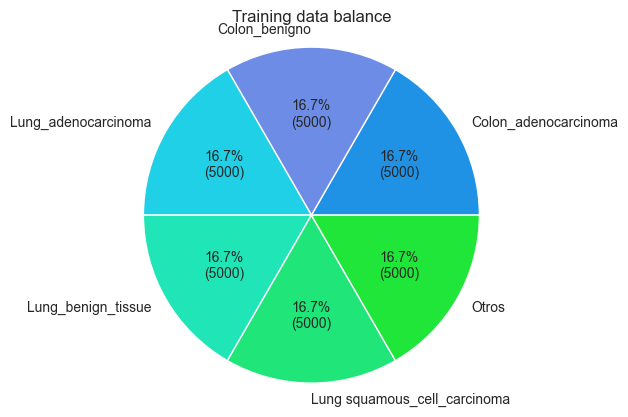

In [4]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6","#20E6B7","#20E67A","#20E63A"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [5]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [6]:
# Custom dataset class for PyTorch
class LungCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
        # Get unique classes and their indices
        self.classes = sorted(dataframe['labels'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        print(f"Found {len(dataframe)} validated image filenames belonging to {len(self.classes)} classes.")
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get image path and label
        img_path = self.dataframe.iloc[idx]['filepaths']
        label = self.dataframe.iloc[idx]['labels']
        
        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Convert label to one-hot encoding
        label_idx = self.class_to_idx[label]
        one_hot = torch.zeros(len(self.classes))
        one_hot[label_idx] = 1.0
        
        return image, one_hot

In [7]:
# Image size and batch size
batch_size = 32
img_size = (224, 224)

# Define transformations (similar to ImageDataGenerator rescale)
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = LungCancerDataset(train_df, transform=transform)
valid_dataset = LungCancerDataset(valid_df, transform=transform)
test_dataset = LungCancerDataset(test_df, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Found 24000 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


In [8]:
# Define the model (equivalent to EfficientNetB3)
class LungCancerModel(nn.Module):
    def __init__(self, num_classes):
        super(LungCancerModel, self).__init__()
        
        # Load pre-trained EfficientNet-B3
        self.efficientnet = models.efficientnet_b3(pretrained=True)
        
        # Freeze early layers (similar to transfer learning in Keras)
        for param in list(self.efficientnet.parameters())[:-30]:
            param.requires_grad = False
            
        # Replace the classifier
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        return self.efficientnet(x)

In [9]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create the model
num_classes = len(train_dataset.classes)
model = LungCancerModel(num_classes=num_classes)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


In [10]:
# Implement early stopping and learning rate scheduler
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [11]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    # Initialize early stopping and learning rate scheduler
    early_stopping = EarlyStopping(patience=5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
    
    # Track best model and metrics
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    # Track history for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            _, labels_max = torch.max(labels, 1)
            running_corrects += torch.sum(preds == labels_max).item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset) * 100
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}%')
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        # No gradient computation for validation
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                _, labels_max = torch.max(labels, 1)
                val_running_corrects += torch.sum(preds == labels_max).item()
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects / len(val_loader.dataset) * 100
        
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.2f}%')
        
        # Adjust learning rate
        scheduler.step(val_epoch_loss)
        
        # Deep copy the best model
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = model.state_dict().copy()
            print(f'New best model with acc: {best_acc:.2f}%')
        
        # Check early stopping
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
        
        print()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f'Best val Acc: {best_acc:.2f}%')
    
    return model, history

In [12]:
# Train the model
model, history = train_model(
    model, 
    train_loader, 
    valid_loader, 
    criterion, 
    optimizer,
    num_epochs=15
)

Epoch 1/15
----------
Train Loss: 0.1165 Acc: 96.13%
Val Loss: 0.0277 Acc: 99.07%
New best model with acc: 99.07%

Epoch 2/15
----------
Train Loss: 0.0519 Acc: 98.20%
Val Loss: 0.0132 Acc: 99.53%
New best model with acc: 99.53%

Epoch 3/15
----------
Train Loss: 0.0344 Acc: 98.80%
Val Loss: 0.0125 Acc: 99.57%
New best model with acc: 99.57%

Epoch 4/15
----------
Train Loss: 0.0226 Acc: 99.21%
Val Loss: 0.0194 Acc: 99.23%

Epoch 5/15
----------
Train Loss: 0.0234 Acc: 99.29%
Val Loss: 0.0140 Acc: 99.57%

Epoch 6/15
----------
Train Loss: 0.0224 Acc: 99.24%
Val Loss: 0.0125 Acc: 99.60%
New best model with acc: 99.60%

Epoch 7/15
----------
Train Loss: 0.0244 Acc: 99.20%
Val Loss: 0.0083 Acc: 99.70%
New best model with acc: 99.70%

Epoch 8/15
----------
Train Loss: 0.0179 Acc: 99.42%
Val Loss: 0.0070 Acc: 99.70%

Epoch 9/15
----------
Train Loss: 0.0145 Acc: 99.52%
Val Loss: 0.0066 Acc: 99.83%
New best model with acc: 99.83%

Epoch 10/15
----------
Train Loss: 0.0145 Acc: 99.50%
Val Los

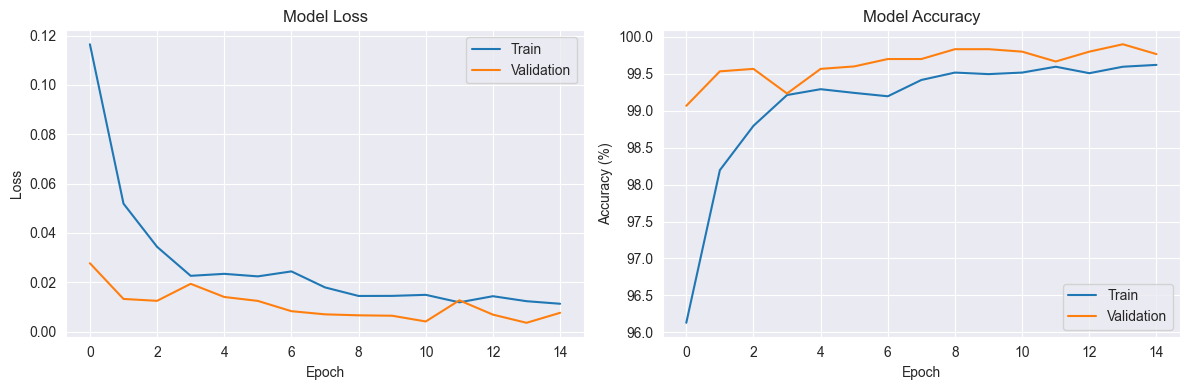

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Evaluate model on test data
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_running_loss = 0.0
    test_running_corrects = 0
    
    # Lists to store all predictions and ground truth
    all_preds = []
    all_labels = []
    
    # No gradient computation for testing
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            test_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            _, labels_max = torch.max(labels, 1)
            test_running_corrects += torch.sum(preds == labels_max).item()
            
            # Store predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_max.cpu().numpy())
    
    test_loss = test_running_loss / len(test_loader.dataset)
    test_acc = test_running_corrects / len(test_loader.dataset) * 100
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}%')
    
    return all_preds, all_labels

Test Loss: 0.0075 Acc: 99.73%


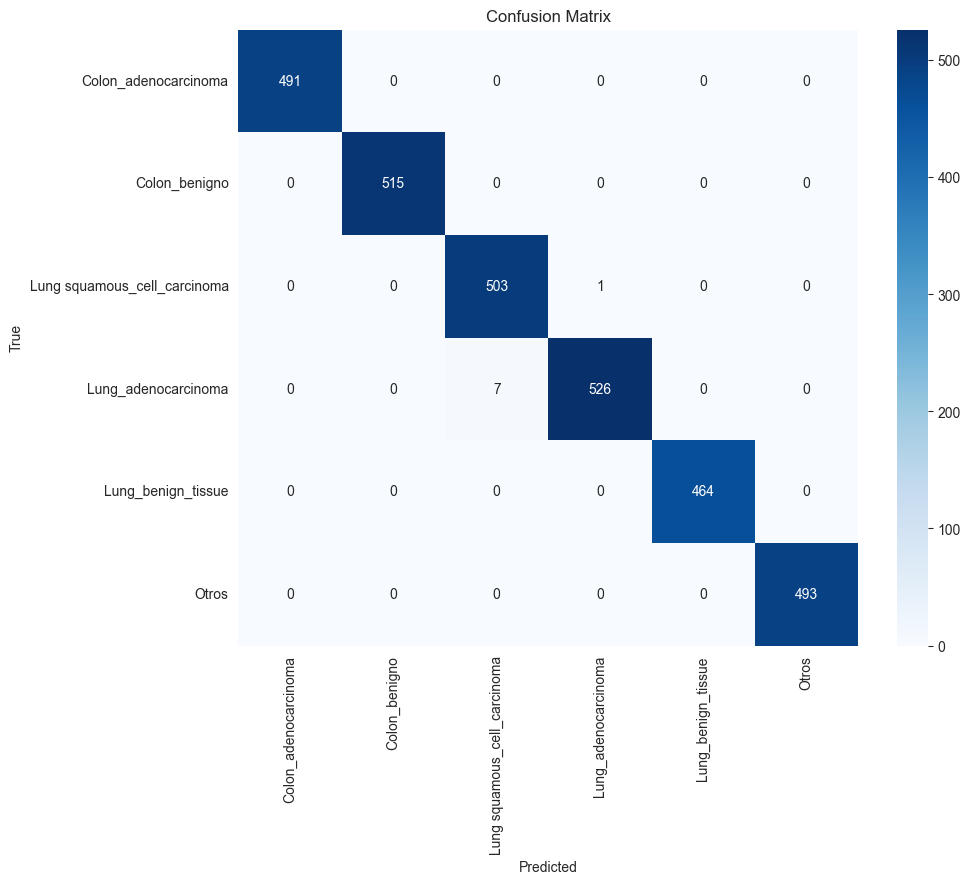


Classification Report:
                              precision    recall  f1-score   support

        Colon_adenocarcinoma       1.00      1.00      1.00       491
               Colon_benigno       1.00      1.00      1.00       515
Lung squamous_cell_carcinoma       0.99      1.00      0.99       504
         Lung_adenocarcinoma       1.00      0.99      0.99       533
          Lung_benign_tissue       1.00      1.00      1.00       464
                       Otros       1.00      1.00      1.00       493

                    accuracy                           1.00      3000
                   macro avg       1.00      1.00      1.00      3000
                weighted avg       1.00      1.00      1.00      3000



In [15]:
# Get predictions on test data
all_preds, all_labels = evaluate_model(model, test_loader, criterion)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

In [18]:
# Save the model
torch.save(model.state_dict(), 'lung_cancer_model_todos.pth')
print("Model saved to lung_cancer_model_todos.pth")

Model saved to lung_cancer_model_todos.pth


In [17]:
print(train_dataset.classes)

['Colon_adenocarcinoma', 'Colon_benigno', 'Lung squamous_cell_carcinoma', 'Lung_adenocarcinoma', 'Lung_benign_tissue', 'Otros']
